In [1]:
# 목차

# ------전처리----------
# 데이터 확인
# 데이터 변환
# 생존여부에 따른 변수값 확인
# 데이터 정규화
# 컬럼 수정
# 데이터 분할

# ------모형-------------
# 모형 만들기(경사하강법)
# cost, epoch, accuracy 확인
# 평가 및 예측
# 가중치 해석

# ------비교------------
# 라이브러리 모형 비교
# 모형 간 가중치 비교
# 샘플적용
      

# min-max 스케일링 전

## Logit

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
np.random.seed(3413)

In [4]:
df=pd.read_csv('./train_titanic.csv')

# 데이터 확인-----------------------------------
 # 종속변수 확인
y_data=df['Survived']


 # 결측치 확인
df.isnull().sum()
df.value_counts

df=df.fillna(value={'Embarked':'S', 'Age':df['Age'].mean()}) 
df=df.round()


# 데이터 변환------------------------------------
# 카테고리형변수 수치화
df['Sex']=df['Sex'].map({'male':0, 'female':1}) 

df['PortS'] = df['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
df['PortC'] = df['Embarked'].apply(lambda x: 1 if x == 'C' else 0)

# 파생변수 생성
df['Family']=df['SibSp']+df['Parch'] 

                Age    Pclass    Family       Fare       Sex     PortS  \
Survived                                                                 
0         30.475410  2.531876  0.883424  22.136612  0.147541  0.777778   
1         28.596491  1.950292  0.938596  48.391813  0.681287  0.640351   

             PortC     PortQ  
Survived                      
0         0.136612  0.085610  
1         0.271930  0.087719  


 *Port값
S    646
C    168
Q     77
Name: Embarked, dtype: int64


 *Port별 생존자비율
Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64 


AxesSubplot(0.125,0.125;0.62x0.755)


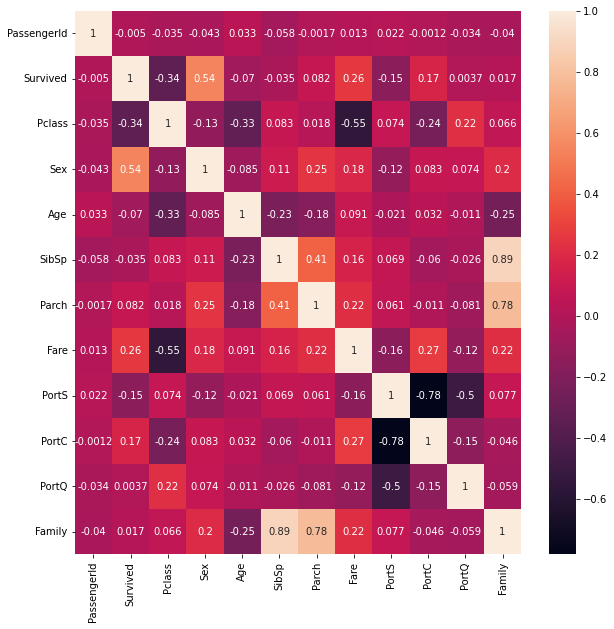

In [5]:
 # 생존여부에 따른 변수값 확인----------------------

mean=df.groupby(by=['Survived'])[['Age', 'Pclass','Family', 'Fare','Sex', 'PortS', 'PortC']].mean()
print(mean)

port1=df['Embarked'].value_counts() #C = Cherbourg, Q = Queenstown, S = Southampton
port2=df.groupby(by=['Embarked'])['Survived'].mean()
print(f'\n\n *Port값\n{port1}\n\n\n *Port별 생존자비율\n{port2} \n\n')

plt.subplots(figsize=(10,10))
cov=sns.heatmap(df.corr(),annot=True)
print(cov)

In [6]:
# 데이터 정규화--------------------------------

df0=df.copy() # 정규화X
df1=df.copy() # 정규화(Min-Max)


# Min-Max Normalization = (X - MIN) / (MAX-MIN) 
def Min_Max(x):
    min=x.min()
    max=x.max()
    normal=(x-min)/(max-min)
    return normal

age1=Min_Max(df['Age'])
fare1=Min_Max(df['Fare'])
family1=Min_Max(df['Family'])
pclass1=Min_Max(df['Pclass'])



# 컬럼 수정-----------------------------------
df1['age']=age1
df1['fare']=fare1
df1['family']=family1
df1['pclass']=pclass1


# 불필요한 변수 삭제
df1.drop(columns=['Survived','Name', 'PassengerId', 'Ticket','Cabin','Age','SibSp','Parch','Fare','Embarked','Family'], axis=1, inplace=True)
df0.drop(columns=['Survived','Name', 'PassengerId', 'Ticket','Cabin','SibSp','Parch','Embarked'], axis=1, inplace=True)


# 컬럼순서 변경
df0=df0[['Sex', 'Age', 'Family', 'Fare', 'Pclass', 'PortS','PortC' ]]
df1=df1[['Sex', 'age', 'family', 'fare', 'pclass', 'PortS','PortC' ]]


In [7]:
# 데이터 분할--------------------------------

# 종속/독립변수 나누기
y_data=y_data
x_data=df0

y_data=np.array(y_data)
x_data=np.array(x_data)



# 학습/검증용 나누기
size = y_data.shape[0] # 891

idx=np.arange(size)    # 일련번호 생성 후 재배열
np.random.shuffle(idx) 

num=int(size*0.7)      # 분리 비율(7:3)

x_train = x_data[idx[:num]] 
x_test = x_data[idx[num:]]
y_train = y_data[idx[:num]]
y_test = y_data[idx[num:]]


In [8]:
# 모형 만들기(경사하강법)-----------------------------

# 활성화함수
def sigmoid(z):    
    return 1/(1+np.exp(-z))


    
# 우도함수 Max
def loss(w,b,x,y):
    global M,N
    
    M = x.shape[0]  # 데이터 갯수
    N = x.shape[1]  # 변수 갯수

    theta = np.dot(x,w)+b
    p = sigmoid(theta)
    diff = (y*np.log(p)+(1-y)*np.log(1-p))  # 우도
    cost = np.sum(diff)*1/(N*M)  # 평균
    return p, cost


    

# 학습진행-----------------------------------------

    # 파라미터 초기화
iter=10000
rate=0.05
w=np.zeros(x_train.shape[1])
b=np.ones(1)

COST=[]
EPOCH=[]
ACCURACY=[]

for count in range(iter):
    p, cost=loss(w, b, x_train, y_train)
    
    # 기울기 구하기
    grad_w = np.dot((-p+y_train),x_train)*1
    grad_b = np.sum(-p+y_train)*1
    
    # 파라미터 갱신
    w = w+rate*grad_w/(N*M)
    b = b+rate*grad_b/(N*M)
    
    # 정확도
    P = np.where(p>0.5, 1, 0)
    predict = np.greater(p, 0.5)
    answer = np.greater(y_train, 0.5)
    test = np.equal(predict, answer)
    accuracy = np.mean(test) # Ture=1로 고려
    
    
    if count % 1000 == 0:
        print(f'iter ={count}, cost ={np.round(cost,3)}, accuracy ={np.round(accuracy,2)}\n',
              f'grad_w ={np.round(grad_w,4)}\n',
              f'grad_b ={np.round(grad_b,4)}\n', 
              f'     w ={np.round(w,4)},\n',
              f'     b ={np.round(b,4)} \n')
        EPOCH.append(count)
        COST.append(cost)
        ACCURACY.append(accuracy)



iter =0, cost =-0.135, accuracy =0.37
 grad_w =[-1.0602000e+00 -6.7846490e+03 -1.8908220e+02 -3.0192761e+03
 -6.1384930e+02 -1.8351420e+02 -2.1996000e+01]
 grad_b =-224.4495
      w =[-0.     -0.0778 -0.0022 -0.0346 -0.007  -0.0021 -0.0003],
      b =[0.9974] 

iter =1000, cost =-0.106, accuracy =0.74
 grad_w =[    8.175  -3738.9963  -116.5469 -4362.6801  -263.8744   -92.5735
   -20.8459]
 grad_b =-117.9182
      w =[ 0.6463 -0.065  -0.2848  0.0098 -0.4373 -0.1846  0.0732],
      b =[0.9445] 

iter =2000, cost =-0.098, accuracy =0.74
 grad_w =[-1.5789000e+00 -3.4894376e+03 -1.1067390e+02 -4.1969679e+03
 -2.3858890e+02 -8.2743500e+01 -2.0667600e+01]
 grad_b =-108.5879
      w =[ 1.1825 -0.0601 -0.2817  0.0074 -0.5203 -0.2549  0.1249],
      b =[0.9734] 



C:\Users\hyeon\AppData\Local\Temp\ipykernel_19576\4703075.py:18: RuntimeWarning: divide by zero encountered in log
  diff = (y*np.log(p)+(1-y)*np.log(1-p))  # 우도
C:\Users\hyeon\AppData\Local\Temp\ipykernel_19576\4703075.py:18: RuntimeWarning: invalid value encountered in multiply
  diff = (y*np.log(p)+(1-y)*np.log(1-p))  # 우도


iter =3000, cost =-0.092, accuracy =0.75
 grad_w =[   -7.9177 -3201.648   -103.1493 -3992.3613  -215.4456   -73.9216
   -19.8942]
 grad_b =-99.2075
      w =[ 1.5961 -0.0572 -0.2857  0.0058 -0.5718 -0.295   0.1603],
      b =[1.0035] 

iter =4000, cost =-0.087, accuracy =0.75
 grad_w =[  -11.883  -2927.3011   -95.3221 -3784.6311  -194.4609   -66.2674
   -18.847 ]
 grad_b =-90.4331
      w =[ 1.9125 -0.0549 -0.292   0.0047 -0.6116 -0.3168  0.185 ],
      b =[1.0314] 

iter =5000, cost =-0.084, accuracy =0.76
 grad_w =[  -14.4181 -2691.9979   -88.445  -3597.732   -176.8728   -60.0332
   -17.7845]
 grad_b =-82.9484
      w =[ 2.1542 -0.0531 -0.2984  0.004  -0.6444 -0.3269  0.2034],
      b =[1.0575] 

iter =6000, cost =-0.082, accuracy =0.76
 grad_w =[  -16.0913 -2500.7856   -82.7809 -3439.7519  -162.779    -55.1387
   -16.8301]
 grad_b =-76.8828
      w =[ 2.3393 -0.0517 -0.3045  0.0034 -0.6722 -0.3294  0.218 ],
      b =[1.0823] 

iter =7000, cost =-0.08, accuracy =0.76
 grad_w =[  -17.

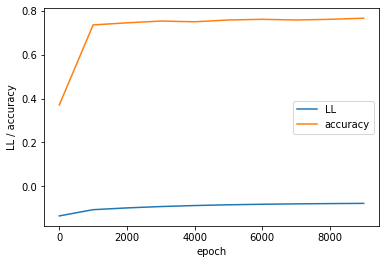

In [9]:
# cost, epoch, accuracy 확인 ------------------

plt.plot(EPOCH, COST, label='LL')
plt.plot(EPOCH, ACCURACY, label='accuracy')

#plt.ylim(-0.1,1)

plt.xlabel('epoch')
plt.ylabel('LL / accuracy')
plt.legend()
plt.show()


In [10]:
# 평가 및 예측-------------------------------

# 예측하기
theta = np.dot(x_test,w)+b
p = sigmoid(theta)
predict=np.where(p>0.5, 1, 0)


# 평가하기
def score(predict, answer):
    
    predict = np.where(predict > 0.5, 1, 0)
    predict_T = np.greater(predict, 0.5)
    predict_F = np.logical_not(predict_T)
    answer_T = np.greater(answer, 0.5)
    answer_F = np.logical_not(answer_T)

    tp = np.sum(np.logical_and(predict_T, answer_T))
    tn = np.sum(np.logical_and(predict_F, answer_F))
    fp = np.sum(np.logical_and(predict_T, answer_F))
    fn = np.sum(np.logical_and(predict_F, answer_T))
    
    accuracy = (tp+tn)/(tp+fn+fp+tn)  
    precision = tp/(tp+fp)  
    recall = tp/(tp+fn)     
    f1 =  2*(precision*recall) / (precision+recall)
    
    return [round(accuracy,5), round(precision,3), round(recall,3), round(f1,3)], [tp,tn, fp,fn,]


print(f'accuracy: {score(predict, y_test)[0][0]}')

accuracy: 0.75373


In [11]:
# 가중치 해석
feature=['bias', 'Sex', 'age', 'family', 'fare', 'pclass', 'PortS', 'PortC']
wb = np.concatenate((b,w),axis=None)
wb = np.round(wb,3)
odds = np.round(np.exp(wb),3)
per = np.round((odds-1),3)

wb_detail=np.vstack((wb,odds,per))
WB = pd.DataFrame(wb_detail, columns=feature, index=['coef','odds','per'])
WB

,bias,Sex,age,family,fare,pclass,PortS,PortC
coef,1.176,2.746,-0.025,-0.322,0.037,-0.749,-0.307,0.263
odds,3.241,15.580,0.975,0.725,1.038,0.473,0.736,1.301
per,2.241,14.580,-0.025,-0.275,0.038,-0.527,-0.264,0.301


In [12]:
# 라이브러리 모형 비교--------------------------------------

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


SK = LogisticRegression(fit_intercept=True) 
SK.fit(x_train, y_train)        
predict_SK = SK.predict(x_test) 
P_SK = SK.predict_proba(x_test)

print(f"  SKepoch={SK.max_iter}, rate={SK.tol}\n",
      f' SK학습: {SK.score(x_train, y_train)}\n',
      f' SK예측: {SK.score(x_test, y_test)}\n\n')
      #print(classification_report(y_test, predict_LR ))


# statsmodel
import statsmodels.api as sm

x_train1=sm.add_constant(x_train, has_constant='add') # 절편추가
logit = sm.Logit(y_train, x_train1)
SM = logit.fit()
     #print(SM.summary2())


  SKepoch=100, rate=0.0001
  SK학습: 0.8025682182985554
  SK예측: 0.8059701492537313




C:\Users\hyeon\anaconda3\envs\knu\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Optimization terminated successfully.
         Current function value: 0.440991
         Iterations 6


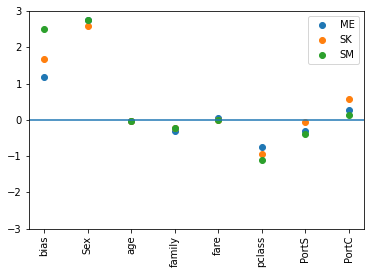

,bias,Sex,age,family,fare,pclass,PortS,PortC
me,1.176,2.746,-0.025,-0.322,0.037,-0.749,-0.307,0.263
SK,1.687,2.590,-0.035,-0.213,0.004,-0.941,-0.059,0.565
SM,2.513,2.741,-0.040,-0.221,0.003,-1.106,-0.381,0.140


In [13]:
# 모형 간 가중치 비교----------------------------

# 가중치

wb_LR=np.concatenate((SK.intercept_,SK.coef_), axis=None)
wb_SM=SM.params
WB=[wb, wb_LR, wb_SM]
weight=pd.DataFrame(WB, columns=feature, index=['me','SK','SM'])



# 시각화
plt.plot(wb, 'o', label='ME')
plt.plot(wb_LR, 'o', label='SK')
plt.plot(wb_SM, 'o', label='SM')

xlims=plt.xlim()
plt.xlim(xlims)
plt.ylim(-3,3)
plt.hlines(0, xlims[0], xlims[1])

plt.xticks(range(N+1), feature, rotation=90 )
plt.legend()
plt.show()


weight.round(3)

In [14]:
# 샘플적용-----------------------------------

# 샘플생성
              # Sex, age, family, fare, Pclass, PS, PC
Jack = np.array([0,   30,   0,     35,   3,     1,  0 ])
Rose = np.array([1,   20,   0,    500,   1,     0,  1 ])
pika = np.array([1,    7,   3,    500,   2,     0,  0 ])

sample = np.array([Jack, Rose, pika])
N = sample.shape[0]



# 샘플 정규화
def normal(sample, method):
    global res
    person=sample.shape[0]
    feature=sample.shape[1]
    res=[]
    if method == 1 :
        print('Min_Max')
        for p in range(person):
            res0=[]   
            for f in range(feature):
                x=df0.iloc[:,f]
                val=sample[p][f]
                output=(val-x.min())/(x.max()-x.min())
                res0.append(output)
            res.append(res0)
    
    else : print('정규화x')
    res=np.array(res)
        
normal(sample,1)


# 예측
 #ME
theta = np.dot(res,w)+b
p_sample = sigmoid(theta)
predict_sample =np.where(p_sample > 0.5, 1, 0)


 #SK
pred_SK=SK.predict(res)
pos_SK=SK.predict_proba(sample)


 #SM
bias=np.ones([res.shape[0]])
sample1=np.column_stack([bias, res])

pos_SM=SM.predict(sample1)
neg_SM=1-pos_SM
pred_SM =np.where(pos_SM>0.5,1,0)



print(f' ME \n',
      f'{predict_sample}\n',          # 생존여부
      f'{np.round(p_sample,2)}\n\n')  # 생존확률

print(f' SK \n',
      f'{pred_SK}\n',
      f'{np.round(pos_SK[:,1],4)}\n\n')

print(f' SM \n',
      f'{pred_SM}\n',
      f'{np.round(pos_SM,2)}\n\n')


Min_Max
 ME 
 [1 1 1]
 [0.53 0.99 0.97]


 SK 
 [1 1 1]
 [0.1076 0.9939 0.968 ]


 SM 
 [1 1 1]
 [0.73 1.   0.99]




## SVM

In [15]:
import tqdm

In [16]:
class Custom_SVM:
    def __init__(self, kernel='linear', C=100.0, max_iter=1000, degree=3, gamma=1):
        self.kernel = {'poly'  : lambda x, y: np.dot(x, y.T)**degree,
                       'rbf'   : lambda x, y: np.exp(-gamma*np.sum((y - x[:, np.newaxis])**2, axis=-1)),
                       'linear': lambda x, y: np.dot(x, y.T)}[kernel]
        self.C = C
        self.max_iter = max_iter

    def restrict_to_square(self, t, v0, u):
        t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
        return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

    def fit(self, X, y):
        self.X = X.copy()
        self.y = y * 2 - 1 # 클래스 범위를 0/1에서 -1/1로 조정
        self.lambdas = np.zeros_like(self.y, dtype=float) # 제약 조건 중 0 이상 범위를 만족하는 lambda 생성
        self.K = self.kernel(self.X, self.X) * self.y[:, np.newaxis] * self.y # kernel matrix 생성
    
        for _ in tqdm.tqdm(range(self.max_iter)):
            for idxM in range(len(self.lambdas)): # lambda_M 반복
                idxL = np.random.randint(0, len(self.lambdas)) # lambda_L 랜덤 선택
                Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]] # lambda_M 및 Lambda_L에 대한 Kernel matrix(Q) 설정
                v0 = self.lambdas[[idxM, idxL]] # v_0 설정
                k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1) # k_0 설정
                u = np.array([-self.y[idxL], self.y[idxM]]) # u 벡터 설정
                t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15) # argmax lambda*(t)를 계산하고, lambda_M 및 Lambda_L이 같은 경우에 업데이트를 위하여 작은 상수를 더함
                self.lambdas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u) # Cost를 활용하여 범위를 제한하여 제약 조건을 충족시킴
    
        idx, = np.nonzero(self.lambdas > 1E-15) # 서포트 벡터 선택
        self.b = np.sum((1.0 - np.sum(self.K[idx] * self.lambdas, axis=1)) * self.y[idx]) / len(idx) # bias 계산
  
    def predict(self, X):
        result = np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b # 선정된 서포트 벡터와 bias를 통해 모델의 클래스 분류
        return np.where(result > 0, 1, 0)
    
    def accuracy(self, y_pred, y_test):
        acc = np.array([1 if pred == test else 0 for pred, test in zip(y_pred, y_test)])
        return acc.sum() / len(acc)

In [17]:
model = Custom_SVM()
model.fit(x_train, y_train)
predict = model.predict(x_test)
model.accuracy(predict, y_test)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.35it/s]


0.6567164179104478

In [18]:
model = Custom_SVM(kernel='rbf')
model.fit(x_train, y_train)
predict = model.predict(x_test)
model.accuracy(predict, y_test)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.41it/s]


0.6156716417910447

In [19]:
model = Custom_SVM(kernel='poly')
model.fit(x_train, y_train)
predict = model.predict(x_test)
model.accuracy(predict, y_test)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.41it/s]


0.6268656716417911

# min-max 스케일링 후

## Logit

In [20]:
# 데이터 분할--------------------------------

# 종속/독립변수 나누기
y_data=y_data
x_data=df1

y_data=np.array(y_data)
x_data=np.array(x_data)



# 학습/검증용 나누기
size = y_data.shape[0] # 891

idx=np.arange(size)    # 일련번호 생성 후 재배열
np.random.shuffle(idx) 

num=int(size*0.7)      # 분리 비율(7:3)

x_train = x_data[idx[:num]] 
x_test = x_data[idx[num:]]
y_train = y_data[idx[:num]]
y_test = y_data[idx[num:]]


In [21]:
iter=10000
rate=0.05
w=np.zeros(x_train.shape[1])
b=np.ones(1)

COST=[]
EPOCH=[]
ACCURACY=[]

for count in range(iter):
    p, cost=loss(w, b, x_train, y_train)
    
    # 기울기 구하기
    grad_w = np.dot((p-y_train),x_train)*1/(N*M)
    grad_b = np.sum(p-y_train)*1/(N*M)
    
    # 파라미터 갱신
    w = w-rate*grad_w
    b = b-rate*grad_b
    
    # 정확도
    P = np.where(p>0.5, 1, 0)
    predict = np.greater(p, 0.5)
    answer = np.greater(y_train, 0.5)
    test = np.equal(predict, answer)
    accuracy = np.mean(test)
    
    
    if count % 1000 == 0:
        print(f'iter ={count}, cost ={np.round(cost,3)}, accuracy ={np.round(accuracy,2)}\n',
              f'grad_w ={np.round(grad_w,4)}\n',
              f'grad_b ={np.round(grad_b,4)}\n', 
              f'     w ={np.round(w,4)},\n',
              f'     b ={np.round(b,4)} \n')
        EPOCH.append(count)
        COST.append(cost)
        ACCURACY.append(accuracy)
      

iter =0, cost =-0.135, accuracy =0.37
 grad_w =[0.001  0.0192 0.0046 0.0016 0.045  0.0414 0.0052]
 grad_b =0.0515
      w =[-0.     -0.001  -0.0002 -0.0001 -0.0023 -0.0021 -0.0003],
      b =[0.9974] 

iter =1000, cost =-0.079, accuracy =0.73
 grad_w =[-0.0115  0.001   0.0003 -0.0005  0.0065  0.0011 -0.0007]
 grad_b =0.0014
      w =[ 0.4967 -0.2608 -0.0601  0.0066 -0.8044 -0.5309 -0.0264],
      b =[0.3449] 

iter =2000, cost =-0.073, accuracy =0.8
 grad_w =[-0.0082  0.0006  0.0004 -0.0003  0.0042  0.     -0.0003]
 grad_b =0.0004
      w =[ 0.9883 -0.2964 -0.0765  0.0283 -1.0624 -0.5479 -0.0013],
      b =[0.3112] 

iter =3000, cost =-0.07, accuracy =0.8
 grad_w =[-0.0059  0.0006  0.0005 -0.0002  0.0032 -0.0001 -0.0002]
 grad_b =0.0003
      w =[ 1.3366 -0.3269 -0.1     0.0407 -1.2462 -0.5446  0.0113],
      b =[0.2937] 

iter =4000, cost =-0.068, accuracy =0.8
 grad_w =[-0.0043  0.0005  0.0006 -0.0001  0.0025 -0.0002 -0.0001]
 grad_b =0.0002
      w =[ 1.5888 -0.3552 -0.1283  0.0473 

In [22]:
# 예측하기
theta = np.dot(x_test,w)+b
p = sigmoid(theta)
predict=np.where(p>0.5, 1, 0)


# 평가하기
print(f'accuracy: {score(predict, y_test)[0][0]}')

accuracy: 0.8209


## SVM

In [23]:
model = Custom_SVM()
model.fit(x_train, y_train)
predict = model.predict(x_test)
model.accuracy(predict, y_test)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.44it/s]


0.8134328358208955

In [ ]:
model = Custom_SVM(kernel='rbf')
model.fit(x_train, y_train)
predict = model.predict(x_test)
model.accuracy(predict, y_test)

 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [00:50<00:03, 18.38it/s]

In [ ]:
model = Custom_SVM(kernel='poly')
model.fit(x_train, y_train)
predict = model.predict(x_test)
model.accuracy(predict, y_test)